In [ ]:
import tensorflow as tf
import matplotlib.image as img
import numpy as np
from collections import defaultdict
import collections
import matplotlib.pyplot as plt
import os
import random
from tensorflow import keras
from tensorflow.keras import models
import pandas as pd
import math
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [ ]:
# Check if GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

2.8.2



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Concatinate both legitmate & DGA domains

In [ ]:
Domain_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ADLDomain_Binary.csv')
Domain_data.drop(["Unnamed: 0"], axis=1, inplace=True)
Domain_data.head()

,domain_name,label,domain
0,odqzesdvd.info,dga,odqzesdvd
1,mcrwnxdzu.info,dga,mcrwnxdzu
2,poxrscvfoy.biz,dga,poxrscvfoy
3,dupzwi.info,dga,dupzwi
4,pgldibr.com,dga,pgldibr


In [ ]:
Domain_data.domain=Domain_data.domain.astype(str)

In [ ]:
from sklearn.preprocessing import LabelEncoder
X = Domain_data.domain
Y = Domain_data['label']
le=LabelEncoder()
Y = le.fit_transform(Y)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential

#max_words = num_words
max_len = 50

# Tokenizer
tok = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,padding='post',maxlen=max_len)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sequences_matrix, Y, test_size=0.20)

### Balancing

In [ ]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()
X_train, y_train = smt.fit_resample(X_train, y_train)

## Load Model and extract feature from an intermidiate layer

In [ ]:
import pickle
# load the model from disk
filename = '/content/drive/My Drive/Colab Notebooks/Bcnnmodel2x32x3_2nd.sav'
loaded_cnn_model = pickle.load(open(filename, 'rb'))

In [ ]:
import pickle
filename = '/content/drive/My Drive/Colab Notebooks/BX_train_sm.csv'
X_train = pickle.load(open(filename, 'rb'))

In [ ]:
filename = '/content/drive/My Drive/Colab Notebooks/By_train_sm.csv'
y_train = pickle.load(open(filename, 'rb'))

In [ ]:
filename = '/content/drive/My Drive/Colab Notebooks/BX_test_sm.csv'
X_test = pickle.load(open(filename, 'rb'))

In [ ]:
filename = '/content/drive/My Drive/Colab Notebooks/By_test_sm.csv'
y_test = pickle.load(open(filename, 'rb'))

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

stppred = loaded_cnn_model.predict(X_test)

In [ ]:
fpr,tpr, _ = metrics.roc_curve(y_test,stppred)
auc = metrics.roc_auc_score(y_test,stppred)

In [ ]:
print(auc)

0.9983812480322465


## CNN

In [ ]:
from keras.models import Sequential
from keras import layers 

embedding_dim = 100
vocab_size=70
max_len = 50
textcnnmodel = Sequential()
textcnnmodel.add(layers.Embedding(vocab_size, embedding_dim, input_length=max_len))
textcnnmodel.add(layers.Conv1D(32, 3, activation='relu'))
textcnnmodel.add(layers.Conv1D(32, 3, activation='relu'))
textcnnmodel.add(layers.GlobalMaxPooling1D())
textcnnmodel.add(layers.Flatten())
textcnnmodel.add(layers.Dense(250, activation='relu'))
textcnnmodel.add(layers.Dense(1, activation='sigmoid'))
textcnnmodel.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])
textcnnmodel.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           7000      
                                                                 
 conv1d (Conv1D)             (None, 48, 32)            9632      
                                                                 
 conv1d_1 (Conv1D)           (None, 46, 32)            3104      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 250)               8250      
                                                        

In [ ]:
import time
start = time.time()
history=textcnnmodel.fit(X_train,y_train,
                     epochs=50,
                     verbose=True,
                     validation_data=(X_test, y_test),
                     batch_size=1000)
end  = time.time()
print("CNN took {} milliseconds to train data.\n".format(end-start))

Epoch 1/50
2341/2341 [==============================] - 32s 8ms/step - loss: 0.1054 - accuracy: 0.9645 - val_loss: 0.0834 - val_accuracy: 0.9714
Epoch 2/50
2341/2341 [==============================] - 19s 8ms/step - loss: 0.0750 - accuracy: 0.9752 - val_loss: 0.0688 - val_accuracy: 0.9760
Epoch 3/50
2341/2341 [==============================] - 20s 8ms/step - loss: 0.0688 - accuracy: 0.9770 - val_loss: 0.0804 - val_accuracy: 0.9724
Epoch 4/50
2341/2341 [==============================] - 19s 8ms/step - loss: 0.0652 - accuracy: 0.9783 - val_loss: 0.0634 - val_accuracy: 0.9780
Epoch 5/50
2341/2341 [==============================] - 19s 8ms/step - loss: 0.0629 - accuracy: 0.9790 - val_loss: 0.0626 - val_accuracy: 0.9786
Epoch 6/50
2341/2341 [==============================] - 19s 8ms/step - loss: 0.0612 - accuracy: 0.9796 - val_loss: 0.0692 - val_accuracy: 0.9762
Epoch 7/50
2341/2341 [==============================] - 20s 8ms/step - loss: 0.0598 - accuracy: 0.9800 - val_loss: 0.0693 - val_ac

In [ ]:
start = time.time()
results = textcnnmodel.evaluate(X_test, y_test)
print ("Accuracy on test set:" , results)
print('Test loss:', results[0])
print('Test accuracy:', results[1])
end  = time.time()
print("CNN took {} milliseconds to test data.\n".format(end-start))

12979/12979 [==============================] - 48s 4ms/step - loss: 0.0529 - accuracy: 0.9813
Accuracy on test set: [0.05289815366268158, 0.9813352227210999]
Test loss: 0.05289815366268158
Test accuracy: 0.9813352227210999
CNN took 48.160942792892456 milliseconds to test data.



In [ ]:
from sklearn.metrics import classification_report
y_cnnpred = textcnnmodel.predict(X_test)
y_cnnpred=(y_cnnpred > 0.5)
print(classification_report(y_test, y_cnnpred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    293300
           1       0.95      0.99      0.97    122028

    accuracy                           0.98    415328
   macro avg       0.97      0.98      0.98    415328
weighted avg       0.98      0.98      0.98    415328



(array([279815.,   3132.,   1869.,   1369.,   1283.,   1262.,   1438.,
          2016.,   3824., 119320.]),
 array([5.4284514e-38, 1.0000000e-01, 2.0000000e-01, 3.0000001e-01,
        4.0000001e-01, 5.0000000e-01, 6.0000002e-01, 6.9999999e-01,
        8.0000001e-01, 8.9999998e-01, 1.0000000e+00], dtype=float32),
 <a list of 10 Patch objects>)

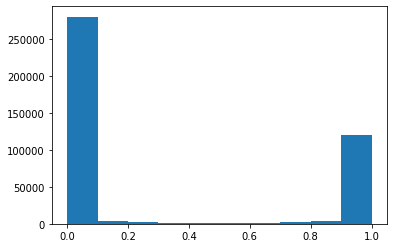

In [ ]:
plt.hist(textcnnmodel.predict(X_test))

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

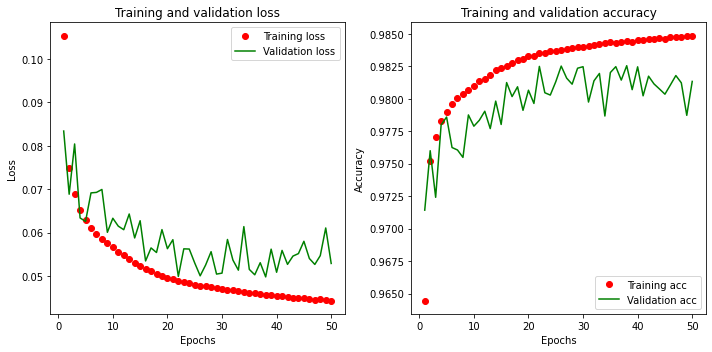

In [ ]:
val_loss = history.history['val_loss']
loss = history.history['loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(accuracy) + 1)

plt.rcParams['figure.figsize'] = [10, 5]
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss', color='red')
plt.plot(epochs,val_loss , 'b', label='Validation loss', color='green')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo', label='Training acc', color='red')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc', color='green')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import pickle
# save the model to disk
filename = '/content/drive/My Drive/Colab Notebooks/Bcnnmodel2x32x3_2nd.sav'
pickle.dump(textcnnmodel, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://18aa0e7d-7087-438b-9ecd-fdb481a77782/assets


## Load Model and extract feature from an intermidiate layer

In [ ]:
import pickle
# load the model from disk
filename = '/content/drive/My Drive/Colab Notebooks/Bcnnmodel2x32x3_2nd.sav'
loaded_cnn_model = pickle.load(open(filename, 'rb'))

In [ ]:
from tensorflow import keras
import time
start = time.time()
layer_name = 'flatten'
intermediate_layer_model = keras.Model(inputs=loaded_cnn_model.input,
                                 outputs=loaded_cnn_model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(X_train)
end = time.time()
print("It took {} milliseconds to extract feature from CNN intermidiate layer.\n".format(end-start))

It took 262.5558252334595 milliseconds to extract feature from CNN intermidiate layer.



### Extra Tree Classifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
import time
start = time.time()
ETmodel = ExtraTreesClassifier().fit(intermediate_output, y_train)
end = time.time()
print("It took {} milliseconds to train ET with feature from CNN intermidiate layer.\n".format(end-start))

It took 911.9694530963898 milliseconds to train ET with feature from CNN intermidiate layer.



In [ ]:
from sklearn.metrics import precision_score, accuracy_score,classification_report
start = time.time()
ETpred = ETmodel.predict(intermediate_layer_model.predict(X_test))
end = time.time()
print(classification_report(y_test, ETpred))
print("It took {} milliseconds to test ET with feature from CNN intermidiate layer.\n".format(end-start))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98    293300
           1       0.94      0.99      0.96    122028

    accuracy                           0.98    415328
   macro avg       0.97      0.98      0.97    415328
weighted avg       0.98      0.98      0.98    415328

It took 105.35104656219482 milliseconds to test ET with feature from CNN intermidiate layer.



In [ ]:
print('accuracy on the train set: ', accuracy_score(ETmodel.predict(intermediate_output), y_train))
print('accuracy on the test set: ', accuracy_score(ETpred, y_test))

accuracy on the train set:  0.99998718283936
accuracy on the test set:  0.9780871985515063


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


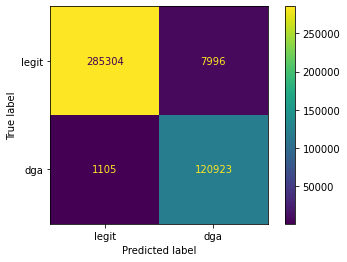

In [ ]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(ETmodel, intermediate_layer_model.predict(X_test), y_test, display_labels=["legit", "dga"])

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

etpprd = ETmodel.predict_proba(intermediate_layer_model.predict(X_test))[::,1]

In [ ]:
fpr,tpr, _ = metrics.roc_curve(y_test,etpprd)
auc = metrics.roc_auc_score(y_test,etpprd)

In [ ]:
print(auc)

0.9975046605256718


<function matplotlib.pyplot.show>

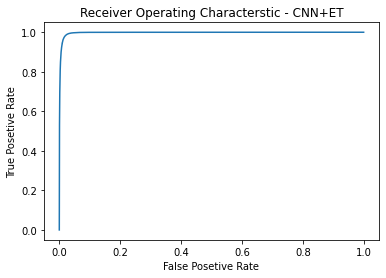

In [ ]:
plt.title('Receiver Operating Characterstic - CNN+ET')
plt.plot(fpr,tpr,label= "AUC = %0.5f" % (auc))
plt.ylabel('True Posetive Rate')
plt.xlabel('False Posetive Rate')
plt.show

In [ ]:
import pickle
# save the model to disk
filename = '/content/drive/My Drive/Colab Notebooks/BCNN+ETmodel.sav'
pickle.dump(ETmodel, open(filename, 'wb'))

#### tune CNN+ET

In [ ]:
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.ensemble import ExtraTreesClassifier
etparams = {'max_depth': [10,20,50,100],
    'criterion': ['gini','entropy']}
etclf = ExtraTreesClassifier()
start = time.time()
etgrid = HalvingGridSearchCV(etclf, etparams, scoring='accuracy', n_jobs=-1).fit(intermediate_output, y_train)
end = time.time()
print("It took {} milliseconds to tune and fit ET with feature from CNN intermidiate layer.\n".format(end-start))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


It took 11644.33060836792 milliseconds to tune and fit ET with feature from CNN intermidiate layer.



In [ ]:
# summarize results
print("Best: %f using %s" % (etgrid.best_score_, etgrid.best_params_))
means = etgrid.cv_results_['mean_test_score']
stds = etgrid.cv_results_['std_test_score']
params = etgrid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
 print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.981240 using {'criterion': 'entropy', 'max_depth': 50}
0.967183 (0.000558) with: {'criterion': 'gini', 'max_depth': 10}
0.977543 (0.000842) with: {'criterion': 'gini', 'max_depth': 20}
0.979737 (0.000829) with: {'criterion': 'gini', 'max_depth': 50}
0.979607 (0.000959) with: {'criterion': 'gini', 'max_depth': 100}
0.967551 (0.000398) with: {'criterion': 'entropy', 'max_depth': 10}
0.977535 (0.000648) with: {'criterion': 'entropy', 'max_depth': 20}
0.979627 (0.000867) with: {'criterion': 'entropy', 'max_depth': 50}
0.979695 (0.000934) with: {'criterion': 'entropy', 'max_depth': 100}
0.981240 (0.000970) with: {'criterion': 'entropy', 'max_depth': 50}
0.981227 (0.001010) with: {'criterion': 'entropy', 'max_depth': 100}
0.981228 (0.000936) with: {'criterion': 'gini', 'max_depth': 50}


In [ ]:
from sklearn.metrics import precision_score, accuracy_score,classification_report
start = time.time()
ETpred = etgrid.predict(intermediate_layer_model.predict(X_test))
end = time.time()
print(classification_report(y_test, ETpred))
print("It took {} milliseconds to test ET with feature from CNN intermidiate layer.\n".format(end-start))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98    293300
           1       0.94      0.99      0.96    122028

    accuracy                           0.98    415328
   macro avg       0.97      0.98      0.97    415328
weighted avg       0.98      0.98      0.98    415328

It took 104.33812546730042 milliseconds to test ET with feature from CNN intermidiate layer.



In [ ]:
print('accuracy on the train set: ', accuracy_score(etgrid.predict(intermediate_output), y_train))
print('accuracy on the test set: ', accuracy_score(ETpred, y_test))

accuracy on the train set:  0.99998718283936
accuracy on the test set:  0.9781257223206719


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


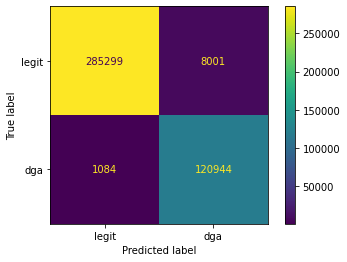

In [ ]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(etgrid, intermediate_layer_model.predict(X_test), y_test, display_labels=["legit", "dga"])

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

etpprd = etgrid.predict_proba(intermediate_layer_model.predict(X_test))[::,1]

In [ ]:
fpr,tpr, _ = metrics.roc_curve(y_test,etpprd)
auc = metrics.roc_auc_score(y_test,etpprd)

In [ ]:
print(auc)

0.9975448294797579


<function matplotlib.pyplot.show>

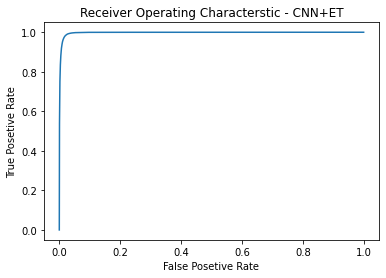

In [ ]:
plt.title('Receiver Operating Characterstic - CNN+ET')
plt.plot(fpr,tpr,label= "AUC = %0.5f" % (auc))
plt.ylabel('True Posetive Rate')
plt.xlabel('False Posetive Rate')
plt.show

In [ ]:
import pickle
# save the model to disk
filename = '/content/drive/My Drive/Colab Notebooks/BCNN+ETmodel_tn.sav'
pickle.dump(etgrid, open(filename, 'wb'))

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import time
start = time.time()
DTmodel = DecisionTreeClassifier().fit(intermediate_output, y_train)
end = time.time()
print("It took {} milliseconds to train DT with feature from CNN intermidiate layer.\n".format(end-start))

It took 327.1390573978424 milliseconds to train DT with feature from CNN intermidiate layer.



In [ ]:
from sklearn.metrics import precision_score, accuracy_score,classification_report
start = time.time()
DTpred = DTmodel.predict(intermediate_layer_model.predict(X_test))
end = time.time()
print(classification_report(y_test, DTpred))
print("It took {} milliseconds to test DT with feature from CNN intermidiate layer.\n".format(end-start))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98    293300
           1       0.92      0.97      0.94    122028

    accuracy                           0.97    415328
   macro avg       0.95      0.97      0.96    415328
weighted avg       0.97      0.97      0.97    415328

It took 33.02642107009888 milliseconds to test DT with feature from CNN intermidiate layer.



In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
average_precision = precision_score(y_test, DTpred)
recall_score=recall_score(y_test, DTpred)
f1_score = f1_score(y_test, DTpred)
accuracy_score = accuracy_score(y_test,DTpred) 
print(average_precision,recall_score,f1_score,accuracy_score)

0.9204010816387139 0.9650981741895303 0.9422198398284676 0.965222667385777


In [ ]:
from sklearn.metrics import precision_score, accuracy_score,classification_report
start = time.time()
DTpred = DTmodel.predict(intermediate_layer_model.predict(X_test))
end = time.time()
print(classification_report(y_test, DTpred))
print("It took {} milliseconds to test DT with feature from CNN intermidiate layer.\n".format(end-start))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98    293300
           1       0.92      0.96      0.94    122028

    accuracy                           0.97    415328
   macro avg       0.95      0.97      0.96    415328
weighted avg       0.97      0.97      0.97    415328

It took 47.78491520881653 milliseconds to test DT with feature from CNN intermidiate layer.



In [ ]:
print('accuracy on the train set: ', accuracy_score(DTmodel.predict(intermediate_output), y_train))
print('accuracy on the test set: ', accuracy_score(DTpred, y_test))

accuracy on the train set:  0.99998718283936
accuracy on the test set:  0.965333423222128


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


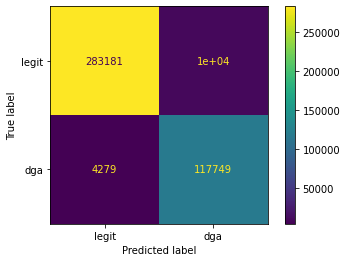

In [ ]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(DTmodel, intermediate_layer_model.predict(X_test), y_test, display_labels=["legit", "dga"])

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

dtpprd = DTmodel.predict_proba(intermediate_layer_model.predict(X_test))[::,1]

In [ ]:
fpr,tpr, _ = metrics.roc_curve(y_test,dtpprd)
auc = metrics.roc_auc_score(y_test,dtpprd)

In [ ]:
print(auc)

0.9652355786844337


<function matplotlib.pyplot.show>

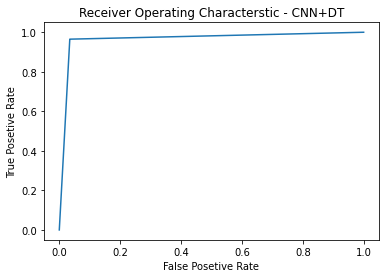

In [ ]:
plt.title('Receiver Operating Characterstic - CNN+DT')
plt.plot(fpr,tpr,label= "AUC = %0.5f" % (auc))
plt.ylabel('True Posetive Rate')
plt.xlabel('False Posetive Rate')
plt.show

In [ ]:
import pickle
# save the model to disk
filename = '/content/drive/My Drive/Colab Notebooks/BCNN+DTmodel.sav'
pickle.dump(DTmodel, open(filename, 'wb'))

#### tuning CNN+DT

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtparams = {'max_depth': [5,10,20,50,100],
    'criterion': ['gini','entropy']}
dtclf = DecisionTreeClassifier()
start = time.time()
dtgrid = HalvingGridSearchCV(dtclf, dtparams, scoring='accuracy', n_jobs=-1).fit(intermediate_output, y_train)
end = time.time()
print("It took {} milliseconds to tune and fit DT with feature from CNN intermidiate layer.\n".format(end-start))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


It took 2242.411283969879 milliseconds to tune and fit DT with feature from CNN intermidiate layer.



In [ ]:
# summarize results
print("Best: %f using %s" % (dtgrid.best_score_, dtgrid.best_params_))
means = dtgrid.cv_results_['mean_test_score']
stds = dtgrid.cv_results_['std_test_score']
params = dtgrid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
 print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.969490 using {'criterion': 'gini', 'max_depth': 20}
0.942334 (0.000923) with: {'criterion': 'gini', 'max_depth': 5}
0.961790 (0.000877) with: {'criterion': 'gini', 'max_depth': 10}
0.960037 (0.001177) with: {'criterion': 'gini', 'max_depth': 20}
0.955096 (0.001159) with: {'criterion': 'gini', 'max_depth': 50}
0.955450 (0.001035) with: {'criterion': 'gini', 'max_depth': 100}
0.939711 (0.002773) with: {'criterion': 'entropy', 'max_depth': 5}
0.960768 (0.000703) with: {'criterion': 'entropy', 'max_depth': 10}
0.957987 (0.001327) with: {'criterion': 'entropy', 'max_depth': 20}
0.957145 (0.001789) with: {'criterion': 'entropy', 'max_depth': 50}
0.956592 (0.001846) with: {'criterion': 'entropy', 'max_depth': 100}
0.963020 (0.000983) with: {'criterion': 'entropy', 'max_depth': 20}
0.965126 (0.000646) with: {'criterion': 'gini', 'max_depth': 20}
0.963267 (0.000797) with: {'criterion': 'entropy', 'max_depth': 10}
0.963418 (0.000371) with: {'criterion': 'gini', 'max_depth': 10}
0.964517 

In [ ]:
from sklearn.metrics import precision_score, accuracy_score,classification_report
start = time.time()
DTpred = dtgrid.predict(intermediate_layer_model.predict(X_test))
end = time.time()
print(classification_report(y_test, DTpred))
print("It took {} milliseconds to test DT with feature from CNN intermidiate layer.\n".format(end-start))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98    293300
           1       0.92      0.97      0.95    122028

    accuracy                           0.97    415328
   macro avg       0.96      0.97      0.96    415328
weighted avg       0.97      0.97      0.97    415328

It took 41.52342104911804 milliseconds to test DT with feature from CNN intermidiate layer.



In [ ]:
print('accuracy on the train set: ', accuracy_score(dtgrid.predict(intermediate_output), y_train))
print('accuracy on the test set: ', accuracy_score(DTpred, y_test))

accuracy on the train set:  0.9905708421558123
accuracy on the test set:  0.9682853070344403


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


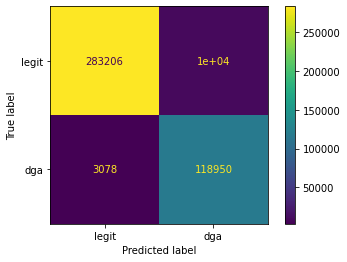

In [ ]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(dtgrid, intermediate_layer_model.predict(X_test), y_test, display_labels=["legit", "dga"])

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

Dtpprd = dtgrid.predict_proba(intermediate_layer_model.predict(X_test))[::,1]

In [ ]:
fpr,tpr, _ = metrics.roc_curve(y_test,Dtpprd)
auc = metrics.roc_auc_score(y_test,Dtpprd)
print(auc)

0.9657561797479622


<function matplotlib.pyplot.show>

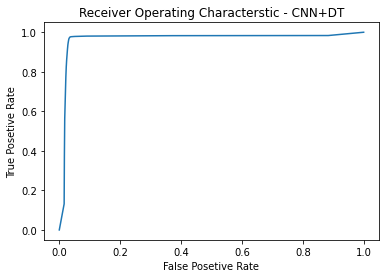

In [ ]:
plt.title('Receiver Operating Characterstic - CNN+DT')
plt.plot(fpr,tpr,label= "AUC = %0.5f" % (auc))
plt.ylabel('True Posetive Rate')
plt.xlabel('False Posetive Rate')
plt.show

In [ ]:
import pickle
# save the model to disk
filename = '/content/drive/My Drive/Colab Notebooks/BCNN+DTmodel_tn.sav'
pickle.dump(dtgrid, open(filename, 'wb'))

## Adaboost Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
import time
start = time.time()
ABmodel = AdaBoostClassifier().fit(intermediate_output, y_train)
end = time.time()
print("It took {} milliseconds to train AB with feature from CNN intermidiate layer.\n".format(end-start))

It took 1058.3013908863068 milliseconds to train AB with feature from CNN intermidiate layer.



In [ ]:
from sklearn.metrics import precision_score, accuracy_score,classification_report
start = time.time()
ABpred = ABmodel.predict(intermediate_layer_model.predict(X_test))
end = time.time()
print(classification_report(y_test, ABpred))
print("It took {} milliseconds to test AB with feature from CNN intermidiate layer.\n".format(end-start))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98    293300
           1       0.92      0.97      0.95    122028

    accuracy                           0.97    415328
   macro avg       0.96      0.97      0.96    415328
weighted avg       0.97      0.97      0.97    415328

It took 85.9472393989563 milliseconds to test AB with feature from CNN intermidiate layer.



In [ ]:
print('accuracy on the train set: ', accuracy_score(ABmodel.predict(intermediate_output), y_train))
print('accuracy on the test set: ', accuracy_score(ABpred, y_test))

accuracy on the train set:  0.9688026037634602
accuracy on the test set:  0.9685357115340165


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


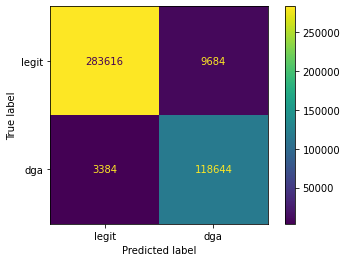

In [ ]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(ABmodel, intermediate_layer_model.predict(X_test), y_test, display_labels=["legit", "dga"])

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

abpprd = ABmodel.predict_proba(intermediate_layer_model.predict(X_test))[::,1]

In [ ]:
fpr,tpr, _ = metrics.roc_curve(y_test,abpprd)
auc = metrics.roc_auc_score(y_test,abpprd)

In [ ]:
print(auc)

0.9939086313810525


<function matplotlib.pyplot.show>

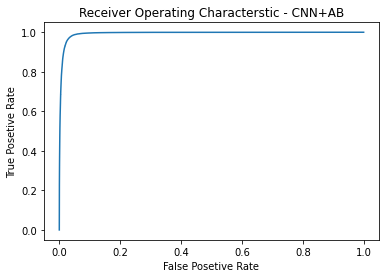

In [ ]:
plt.title('Receiver Operating Characterstic - CNN+AB')
plt.plot(fpr,tpr,label= "AUC = %0.5f" % (auc))
plt.ylabel('True Posetive Rate')
plt.xlabel('False Posetive Rate')
plt.show

In [ ]:
import pickle
# save the model to disk
filename = '/content/drive/My Drive/Colab Notebooks/BCNN+ABmodel.sav'
pickle.dump(ABmodel, open(filename, 'wb'))

#### tuning AB

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
abparams = {'learning_rate': [0.001,0.01, 0.1, 1] 
            }
abclf = AdaBoostClassifier()
start = time.time()
abgrid = HalvingGridSearchCV(abclf, abparams, scoring='accuracy', n_jobs=-1).fit(intermediate_output, y_train)
end = time.time()
print("It took {} milliseconds to tune and fit AB with feature from CNN intermidiate layer.\n".format(end-start))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


It took 7750.068004369736 milliseconds to tune and fit AB with feature from CNN intermidiate layer.



In [ ]:
# summarize results
print("Best: %f using %s" % (abgrid.best_score_, abgrid.best_params_))
means = abgrid.cv_results_['mean_test_score']
stds = abgrid.cv_results_['std_test_score']
params = abgrid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
 print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.967681 using {'learning_rate': 1}
0.832233 (0.001591) with: {'learning_rate': 0.001}
0.885560 (0.002108) with: {'learning_rate': 0.01}
0.947233 (0.000775) with: {'learning_rate': 0.1}
0.967735 (0.001459) with: {'learning_rate': 1}
0.946969 (0.001180) with: {'learning_rate': 0.1}
0.967681 (0.001488) with: {'learning_rate': 1}


In [ ]:
from sklearn.metrics import precision_score, accuracy_score,classification_report
start = time.time()
ABpred = abgrid.predict(intermediate_layer_model.predict(X_test))
end = time.time()
print(classification_report(y_test, ABpred))
print("It took {} milliseconds to test AB with feature from CNN intermidiate layer.\n".format(end-start))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98    293300
           1       0.92      0.97      0.95    122028

    accuracy                           0.97    415328
   macro avg       0.96      0.97      0.96    415328
weighted avg       0.97      0.97      0.97    415328

It took 37.932677268981934 milliseconds to test AB with feature from CNN intermidiate layer.



In [ ]:
print('accuracy on the train set: ', accuracy_score(abgrid.predict(intermediate_output), y_train))
print('accuracy on the test set: ', accuracy_score(ABpred, y_test))

accuracy on the train set:  0.9688026037634602
accuracy on the test set:  0.9685357115340165


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


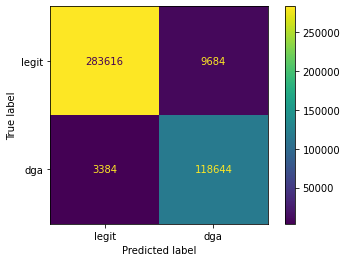

In [ ]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(abgrid, intermediate_layer_model.predict(X_test), y_test, display_labels=["legit", "dga"])

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

pprd = abgrid.predict_proba(intermediate_layer_model.predict(X_test))[::,1]

In [ ]:
fpr,tpr, _ = metrics.roc_curve(y_test,pprd)
auc = metrics.roc_auc_score(y_test, pprd)
print(auc)

0.9939086313810525


<function matplotlib.pyplot.show>

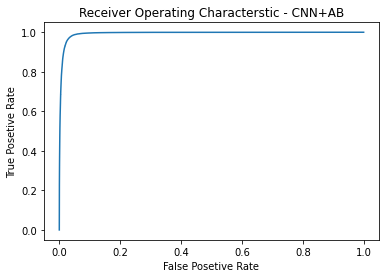

In [ ]:
plt.title('Receiver Operating Characterstic - CNN+AB')
plt.plot(fpr,tpr,label= "AUC = %0.5f" % (auc))
plt.ylabel('True Posetive Rate')
plt.xlabel('False Posetive Rate')
plt.show

In [ ]:
import pickle
# save the model to disk
filename = '/content/drive/My Drive/Colab Notebooks/BCNN+ABmodel_tn.sav'
pickle.dump(abgrid, open(filename, 'wb'))

## XGBoost Classifier

In [ ]:
from xgboost import XGBClassifier
start = time.time()
XGBmodel = XGBClassifier().fit(intermediate_output, y_train)
end = time.time()
print("It took {} milliseconds to train XGB with feature from CNN intermidiate layer.\n".format(end-start))

It took 1177.1565301418304 milliseconds to train XGB with feature from CNN intermidiate layer.



In [ ]:
from sklearn.metrics import precision_score, accuracy_score,classification_report
start = time.time()
xgbpred = XGBmodel.predict(intermediate_layer_model.predict(X_test))
end = time.time()
print("It took {} milliseconds to test XGB with feature from CNN intermidiate layer.\n".format(end-start))
print(classification_report(y_test, xgbpred))

It took 83.80255794525146 milliseconds to test XGB with feature from CNN intermidiate layer.

              precision    recall  f1-score   support

           0       0.99      0.97      0.98    293300
           1       0.93      0.98      0.95    122028

    accuracy                           0.97    415328
   macro avg       0.96      0.98      0.97    415328
weighted avg       0.97      0.97      0.97    415328



In [ ]:
print('accuracy on the train set: ', accuracy_score(XGBmodel.predict(intermediate_output), y_train))
print('accuracy on the test set: ', accuracy_score(xgbpred, y_test))

accuracy on the train set:  0.9756486764999923
accuracy on the test set:  0.9724169812774481


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


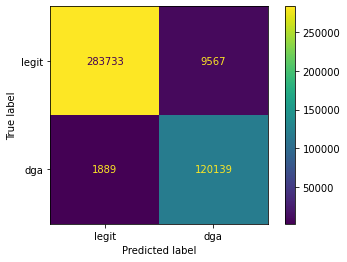

In [ ]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(XGBmodel, intermediate_layer_model.predict(X_test), y_test, display_labels=["legit", "dga"])

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

xgbpprd = XGBmodel.predict_proba(intermediate_layer_model.predict(X_test))[::,1]

In [ ]:
fpr,tpr, _ = metrics.roc_curve(y_test,xgbpprd)
auc = metrics.roc_auc_score(y_test,xgbpprd)

In [ ]:
print(auc)

0.9955376060002482


<function matplotlib.pyplot.show>

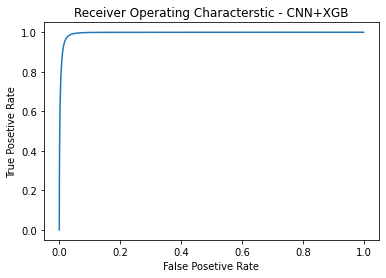

In [ ]:
plt.title('Receiver Operating Characterstic - CNN+XGB')
plt.plot(fpr,tpr,label= "AUC = %0.5f" % (auc))
plt.ylabel('True Posetive Rate')
plt.xlabel('False Posetive Rate')
plt.show

In [ ]:
import pickle
# save the model to disk
filename = '/content/drive/My Drive/Colab Notebooks/BCNN+XGBmodel.sav'
pickle.dump(XGBmodel, open(filename, 'wb'))

#### tuning XGB

In [ ]:
from xgboost import XGBClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier

xgbparams = {'learning_rate': [0.001,0.01, 0.1, 1],
             'max_depth': [5,10,20,50,100]}
xgbclf = XGBClassifier()
start = time.time()
xgbgrid = HalvingGridSearchCV(xgbclf, xgbparams, scoring='accuracy', n_jobs=-1).fit(intermediate_output, y_train)
end = time.time()
print("It took {} milliseconds to tune and fit AB with feature from CNN intermidiate layer.\n".format(end-start))

In [ ]:
# summarize results
print("Best: %f using %s" % (xgbgrid.best_score_, xgbgrid.best_params_))
means = xgbgrid.cv_results_['mean_test_score']
stds = xgbgrid.cv_results_['std_test_score']
params = xgbgrid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
 print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
from sklearn.metrics import precision_score, accuracy_score,classification_report
start = time.time()
xgbpred = xgbgrid.predict(intermediate_layer_model.predict(X_test))
end = time.time()
print(classification_report(y_test, xgbpred))
print("It took {} milliseconds to test AB with feature from CNN intermidiate layer.\n".format(end-start))

In [ ]:
print('accuracy on the train set: ', accuracy_score(xgbgrid.predict(intermediate_output), y_train))
print('accuracy on the test set: ', accuracy_score(xgbpred, y_test))

In [ ]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(xgbgrid, intermediate_layer_model.predict(X_test), y_test, display_labels=["legit", "dga"])

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

pprd = xgbgrid.predict_proba(intermediate_layer_model.predict(X_test))[::,1]

In [ ]:
fpr,tpr, _ = metrics.roc_curve(y_test,pprd)
auc = metrics.roc_auc_score(y_test, pprd)
print(auc)

In [ ]:
plt.title('Receiver Operating Characterstic - CNN+XGB')
plt.plot(fpr,tpr,label= "AUC = %0.5f" % (auc))
plt.ylabel('True Posetive Rate')
plt.xlabel('False Posetive Rate')
plt.show

In [ ]:
import pickle
# save the model to disk
filename = '/content/drive/My Drive/Colab Notebooks/BCNN+XGBmodel_tn.sav'
pickle.dump(xgbgrid, open(filename, 'wb'))

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
start = time.time()
Lreg = LogisticRegression().fit(intermediate_output, y_train)
end = time.time()
print("It took {} milliseconds to train LR with feature from CNN intermidiate layer.\n".format(end-start))

It took 32.57629704475403 milliseconds to train LR with feature from CNN intermidiate layer.



In [ ]:
from sklearn.metrics import precision_score, accuracy_score,classification_report
start = time.time()
Lregy_pred = Lreg.predict(intermediate_layer_model.predict(X_test))
end = time.time()
print("It took {} milliseconds to test LR with feature from CNN intermidiate layer.\n".format(end-start))
print(classification_report(y_test, Lregy_pred))

It took 70.80802059173584 milliseconds to test LR with feature from CNN intermidiate layer.

              precision    recall  f1-score   support

           0       0.99      0.96      0.98    293300
           1       0.92      0.98      0.95    122028

    accuracy                           0.97    415328
   macro avg       0.95      0.97      0.96    415328
weighted avg       0.97      0.97      0.97    415328



In [ ]:
print('accuracy on the train set: ', accuracy_score(Lreg.predict(intermediate_output), y_train))
print('accuracy on the test set: ', accuracy_score(Lregy_pred, y_test))

accuracy on the train set:  0.9678383260446413
accuracy on the test set:  0.9670381000077047


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


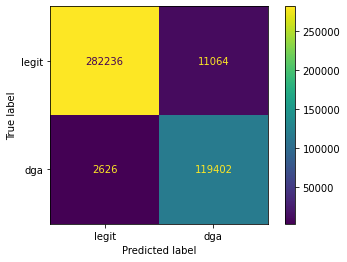

In [ ]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(Lreg, intermediate_layer_model.predict(X_test), y_test, display_labels=["legit", "dga"])

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

lrpprd = Lreg.predict_proba(intermediate_layer_model.predict(X_test))[::,1]

In [ ]:
fpr,tpr, _ = metrics.roc_curve(y_test,lrpprd)
auc = metrics.roc_auc_score(y_test,lrpprd)

In [ ]:
print(auc)

0.9932479858853386


<function matplotlib.pyplot.show>

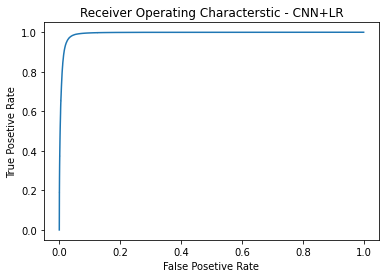

In [ ]:
plt.title('Receiver Operating Characterstic - CNN+LR')
plt.plot(fpr,tpr,label= "AUC = %0.5f" % (auc))
plt.ylabel('True Posetive Rate')
plt.xlabel('False Posetive Rate')
plt.show

In [ ]:
import pickle
# save the model to disk
filename = '/content/drive/My Drive/Colab Notebooks/BCNN+LRmodel.sav'
pickle.dump(Lreg, open(filename, 'wb'))

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
start = time.time()
gnb = GaussianNB().fit(intermediate_output, y_train)
end = time.time()
print("It took {} milliseconds to train NB with feature from CNN intermidiate layer.\n".format(end-start))

It took 2.6906628608703613 milliseconds to train NB with feature from CNN intermidiate layer.



In [ ]:
from sklearn.metrics import precision_score, accuracy_score,classification_report
start = time.time()
gnb_pred = gnb.predict(intermediate_layer_model.predict(X_test))
end = time.time()
print("It took {} milliseconds to test NB with feature from CNN intermidiate layer.\n".format(end-start))
print(classification_report(y_test, gnb_pred))

It took 82.31965756416321 milliseconds to test NB with feature from CNN intermidiate layer.

              precision    recall  f1-score   support

           0       0.96      0.96      0.96    293300
           1       0.90      0.90      0.90    122028

    accuracy                           0.94    415328
   macro avg       0.93      0.93      0.93    415328
weighted avg       0.94      0.94      0.94    415328



In [ ]:
print('accuracy on the train set: ', accuracy_score(gnb.predict(intermediate_output), y_train))
print('accuracy on the test set: ', accuracy_score(gnb_pred, y_test))

accuracy on the train set:  0.9313547055214619
accuracy on the test set:  0.942917405038909


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


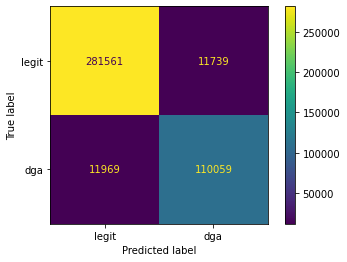

In [ ]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(gnb, intermediate_layer_model.predict(X_test), y_test, display_labels=["legit", "dga"])

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

nbpprd = gnb.predict_proba(intermediate_layer_model.predict(X_test))[::,1]

In [ ]:
fpr,tpr, _ = metrics.roc_curve(y_test,nbpprd)
auc = metrics.roc_auc_score(y_test,nbpprd)

In [ ]:
print(auc)

0.9816673038553325


<function matplotlib.pyplot.show>

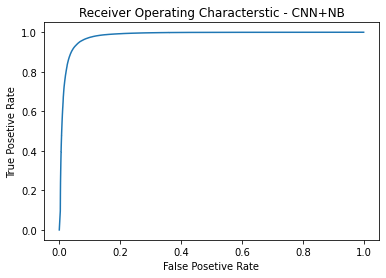

In [ ]:
plt.title('Receiver Operating Characterstic - CNN+NB')
plt.plot(fpr,tpr,label= "AUC = %0.5f" % (auc))
plt.ylabel('True Posetive Rate')
plt.xlabel('False Posetive Rate')
plt.show

In [ ]:
import pickle
# save the model to disk
filename = '/content/drive/My Drive/Colab Notebooks/BCNN+NBmodel.sav'
pickle.dump(gnb, open(filename, 'wb'))

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
start = time.time()
RFmodel = RandomForestClassifier().fit(intermediate_output, y_train)
end = time.time()
print("It took {} milliseconds to train RF with feature from CNN intermidiate layer.\n".format(end-start))

It took 2808.5327038764954 milliseconds to train RF with feature from CNN intermidiate layer.



In [ ]:
from sklearn.metrics import precision_score, accuracy_score,classification_report
start = time.time()
RFpred = RFmodel.predict(intermediate_layer_model.predict(X_test))
end = time.time()
print("It took {} milliseconds to test LR with feature from CNN intermidiate layer.\n".format(end-start))
print(classification_report(y_test, RFpred))

It took 53.42053484916687 milliseconds to test LR with feature from CNN intermidiate layer.

              precision    recall  f1-score   support

           0       1.00      0.97      0.99    293300
           1       0.94      0.99      0.97    122028

    accuracy                           0.98    415328
   macro avg       0.97      0.98      0.98    415328
weighted avg       0.98      0.98      0.98    415328



In [ ]:
print('accuracy on the train set: ', accuracy_score(RFmodel.predict(intermediate_output), y_train))
print('accuracy on the test set: ', accuracy_score(RFpred, y_test))

accuracy on the train set:  0.99998291045248
accuracy on the test set:  0.9790984474921026


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


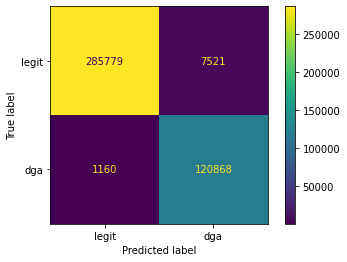

In [ ]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(RFmodel, intermediate_layer_model.predict(X_test), y_test, display_labels=["legit", "dga"])

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

rfpprd = RFmodel.predict_proba(intermediate_layer_model.predict(X_test))[::,1]

In [ ]:
fpr,tpr, _ = metrics.roc_curve(y_test,rfpprd)
auc = metrics.roc_auc_score(y_test,rfpprd)

In [ ]:
print(auc)

0.9974969134955985


<function matplotlib.pyplot.show>

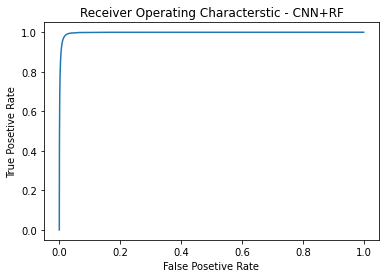

In [ ]:
plt.title('Receiver Operating Characterstic - CNN+RF')
plt.plot(fpr,tpr,label= "AUC = %0.5f" % (auc))
plt.ylabel('True Posetive Rate')
plt.xlabel('False Posetive Rate')
plt.show

In [ ]:
import pickle
# save the model to disk
filename = '/content/drive/My Drive/Colab Notebooks/BCNN+RFmodel.sav'
pickle.dump(RFmodel, open(filename, 'wb'))